# **Modelo LSTM para clasificación de acciones en videos UCF101**

In [1]:
# imports

import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuración

In [3]:
PKL_PATH = "/content/drive/MyDrive/ucf101_2d.pkl"
SELECTED_CLASSES = [0, 1, 2, 3, 4]
BATCH = 16
EPOCHS = 5
LR = 1e-3
MAX_FRAMES = 300
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Dispositivo: {DEVICE}")
print(f"Clases seleccionadas: {SELECTED_CLASSES}")
print(f"Batch size: {BATCH}, Epochs: {EPOCHS}, LR: {LR}")

Dispositivo: cpu
Clases seleccionadas: [0, 1, 2, 3, 4]
Batch size: 16, Epochs: 5, LR: 0.001


# Carga de datos

In [4]:
print(f"\nVerificando archivo: {PKL_PATH}")
if not os.path.exists(PKL_PATH):
    raise FileNotFoundError(f"El archivo {PKL_PATH} no existe. Verifica la ruta.")

file_size = os.path.getsize(PKL_PATH)
print(f"Tamaño del archivo: {file_size} bytes ({file_size / (1024*1024):.2f} MB)")

if file_size == 0:
    raise ValueError(f"El archivo {PKL_PATH} está vacío (0 bytes).")

try:
    with open(PKL_PATH, "rb") as f:
        data = pickle.load(f)
    print("✓ Archivo pickle cargado correctamente")
except pickle.UnpicklingError as e:
    print(f"✗ Error al cargar pickle: {e}")
    try:
        with open(PKL_PATH, "rb") as f:
            unpickler = pickle.Unpickler(f)
            data = unpickler.load()
        print("✓ Cargado con método alternativo")
    except Exception as e2:
        print(f"✗ También falló: {e2}")
        raise
except Exception as e:
    print(f"✗ Error inesperado: {e}")
    raise

annotations = data["annotations"]
print(f"✓ Cargadas {len(annotations)} anotaciones")

# Filtrar por clases
ann_filtered = [a for a in annotations if a["label"] in SELECTED_CLASSES]
print(f"✓ Anotaciones filtradas: {len(ann_filtered)}")

# Distribución de clases
class_dist = defaultdict(int)
for a in ann_filtered:
    class_dist[a["label"]] += 1
print("\nDistribución de clases:")
for cls, count in sorted(class_dist.items()):
    print(f"  Clase {cls}: {count} muestras")


Verificando archivo: /content/drive/MyDrive/ucf101_2d.pkl
Tamaño del archivo: 1070780736 bytes (1021.18 MB)
✓ Archivo pickle cargado correctamente
✓ Cargadas 13320 anotaciones
✓ Anotaciones filtradas: 644

Distribución de clases:
  Clase 0: 145 muestras
  Clase 1: 114 muestras
  Clase 2: 145 muestras
  Clase 3: 132 muestras
  Clase 4: 108 muestras


# Preprocesamiento

In [6]:
def preprocess(a):
    kp = a["keypoint"]
    # Tomar solo 1 persona M=1
    kp = kp[0]

    # Pasar a (T, V*2)
    kp = kp.reshape(kp.shape[0], -1).astype(np.float32)

    # Normalizar
    kp = kp - kp.mean()
    std = kp.std()
    if std > 0:
        kp = kp / std

    # Pad/truncate a longitud fija
    T = kp.shape[0]
    if T >= MAX_FRAMES:
        kp = kp[:MAX_FRAMES]
    else:
        pad = np.zeros((MAX_FRAMES - T, kp.shape[1]), dtype=np.float32)
        kp = np.vstack([kp, pad])

    return kp

# Dataset

In [7]:
class UCFDataset(Dataset):
    def __init__(self, ann_list):
        self.ann = ann_list

    def __len__(self):
        return len(self.ann)

    def __getitem__(self, idx):
        a = self.ann[idx]
        x = preprocess(a)
        y = a["label"]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Split train/val
train_split = int(0.8 * len(ann_filtered))
train_ds = UCFDataset(ann_filtered[:train_split])
val_ds = UCFDataset(ann_filtered[train_split:])
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH)

print(f"\n✓ Train: {len(train_ds)} muestras")
print(f"✓ Val: {len(val_ds)} muestras")


✓ Train: 515 muestras
✓ Val: 129 muestras


# Modelo LSTM

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1]  # Tomar última salida
        return self.fc(last)

# Inicializar modelo
example = preprocess(ann_filtered[0])
input_dim = example.shape[1]
num_classes = len(SELECTED_CLASSES)

print(f"\n✓ Input dim: {input_dim}")
print(f"✓ Num classes: {num_classes}")

model = LSTMModel(input_dim, 128, num_classes).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Parámetros totales: {total_params:,}")
print(f"✓ Parámetros entrenables: {trainable_params:,}")


✓ Input dim: 34
✓ Num classes: 5
✓ Parámetros totales: 84,613
✓ Parámetros entrenables: 84,613


# Entrenamiento con métricas

In [10]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    train_losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        X, y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    history['train_loss'].append(avg_train_loss)

    # Validación
    model.eval()
    val_losses = []
    preds, labels = [], []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits = model(X)
            loss = loss_fn(logits, y)
            val_losses.append(loss.item())

            y_pred = logits.argmax(1).cpu().numpy()
            preds += list(y_pred)
            labels += list(y.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    acc = accuracy_score(labels, preds)

    # Métricas
    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(acc)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Acc: {acc:.4f}")
    print(f"  Val Precision: {precision:.4f}")
    print(f"  Val Recall: {recall:.4f}")
    print(f"  Val F1: {f1:.4f}")


Epoch 1/5 [Val]: 100%|██████████| 9/9 [00:00<00:00, 26.67it/s]



Epoch 1/5
  Train Loss: 1.5961
  Val Loss: 1.6680
  Val Acc: 0.0233
  Val Precision: 0.1362
  Val Recall: 0.0233
  Val F1: 0.0397


Epoch 2/5 [Val]: 100%|██████████| 9/9 [00:00<00:00, 19.39it/s]



Epoch 2/5
  Train Loss: 1.5657
  Val Loss: 1.6827
  Val Acc: 0.0465
  Val Precision: 0.4089
  Val Recall: 0.0465
  Val F1: 0.0833


Epoch 3/5 [Val]: 100%|██████████| 9/9 [00:00<00:00, 27.30it/s]



Epoch 3/5
  Train Loss: 1.7712
  Val Loss: 1.9296
  Val Acc: 0.3178
  Val Precision: 0.2925
  Val Recall: 0.3178
  Val F1: 0.2135


Epoch 4/5 [Val]: 100%|██████████| 9/9 [00:00<00:00, 16.51it/s]



Epoch 4/5
  Train Loss: 1.5666
  Val Loss: 1.7054
  Val Acc: 0.0465
  Val Precision: 0.4884
  Val Recall: 0.0465
  Val F1: 0.0843


Epoch 5/5 [Val]: 100%|██████████| 9/9 [00:00<00:00, 26.26it/s]


Epoch 5/5
  Train Loss: 1.5670
  Val Loss: 1.6923
  Val Acc: 0.0465
  Val Precision: 0.4089
  Val Recall: 0.0465
  Val F1: 0.0833


# Visualizaciones

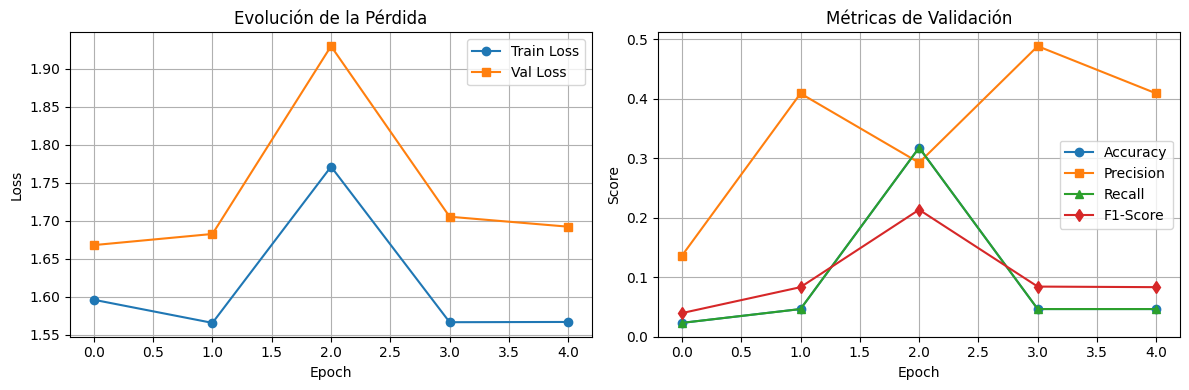

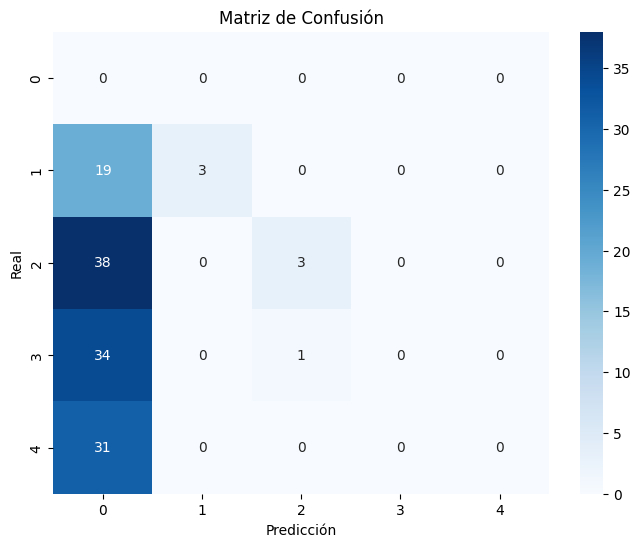

In [13]:
# 1. Gráfica de pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.grid(True)

# 2. Gráfica de métricas
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Accuracy', marker='o')
plt.plot(history['val_precision'], label='Precision', marker='s')
plt.plot(history['val_recall'], label='Recall', marker='^')
plt.plot(history['val_f1'], label='F1-Score', marker='d')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Métricas de Validación')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Matriz de confusión
model.eval()
final_preds, final_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(DEVICE)
        logits = model(X)
        y_pred = logits.argmax(1).cpu().numpy()
        final_preds += list(y_pred)
        final_labels += list(y.numpy())

cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()



# Método de inferencia

In [15]:
def predict_video(model, annotation, class_names=None):
    model.eval()
    x = preprocess(annotation)
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_class = logits.argmax(1).item()
        confidence = probs[0][pred_class].item()

    result = {
        'predicted_class': pred_class,
        'confidence': confidence,
        'probabilities': {i: probs[0][i].item() for i in range(len(SELECTED_CLASSES))}
    }

    if class_names:
        result['predicted_class_name'] = class_names[pred_class]

    return result

def predict_from_file(model, pkl_path, video_idx, class_names=None):
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    annotations = data["annotations"]
    ann_filtered = [a for a in annotations if a["label"] in SELECTED_CLASSES]

    if video_idx >= len(ann_filtered):
        raise ValueError(f"Índice {video_idx} fuera de rango. Máximo: {len(ann_filtered)-1}")

    annotation = ann_filtered[video_idx]
    true_label = annotation["label"]
    result = predict_video(model, annotation, class_names)
    result['true_label'] = true_label

    return result

print("Ejemplo de inferencia")

# Probar con algunos videos de validación
for i in range(min(5, len(val_ds))):
    annotation = ann_filtered[train_split + i]
    result = predict_video(model, annotation)
    true_label = annotation["label"]

    print(f"\nVideo {i+1}:")
    print(f"  Clase real: {true_label}")
    print(f"  Clase predicha: {result['predicted_class']}")
    print(f"  Confianza: {result['confidence']:.4f}")
    print(f"  Correcto: {'✓' if result['predicted_class'] == true_label else '✗'}")

Ejemplo de inferencia

Video 1:
  Clase real: 1
  Clase predicha: 0
  Confianza: 0.2891
  Correcto: ✗

Video 2:
  Clase real: 1
  Clase predicha: 0
  Confianza: 0.2891
  Correcto: ✗

Video 3:
  Clase real: 1
  Clase predicha: 0
  Confianza: 0.2891
  Correcto: ✗

Video 4:
  Clase real: 1
  Clase predicha: 0
  Confianza: 0.2891
  Correcto: ✗

Video 5:
  Clase real: 1
  Clase predicha: 0
  Confianza: 0.2891
  Correcto: ✗


Interfaz de consola para inferencia

In [19]:
def interactive_inference():
    print("Interfaz de inferencia interactiva")

    print(f"videos disponibles: 0-{len(ann_filtered)-1}")
    print("escribe 'salir' para terminar\n")

    while True:
        try:
            user_input = input("ingresa el índice del video o salir: ").strip()

            if user_input.lower() in ['salir', 'exit', 'quit']:
                print("...")
                break

            video_idx = int(user_input)

            if video_idx < 0 or video_idx >= len(ann_filtered):
                print(f"indice fuera de rango. Usa 0-{len(ann_filtered)-1}")
                continue

            annotation = ann_filtered[video_idx]
            result = predict_video(model, annotation)
            true_label = annotation["label"]

            print(f"\n video #{video_idx}")
            print(f"   clase real: {true_label}")
            print(f"   clase predicha: {result['predicted_class']}")
            print(f"   confianza: {result['confidence']:.2%}")
            print(f"   resultado: {'correcto' if result['predicted_class'] == true_label else 'incorrecto'}")
            print(f"\n   probabilidades por clase:")
            for cls, prob in sorted(result['probabilities'].items(),
                                   key=lambda x: x[1], reverse=True):
                marker = "  " if cls == result['predicted_class'] else "  "
                print(f"   {marker} Clase {cls}: {prob:.2%}")
            print()

        except ValueError:
            print("ingresa un número válido")
        except KeyboardInterrupt:
            print("\n salir")
            break
        except Exception as e:
            print(f"error: {e}")

interactive_inference()

Interfaz de inferencia interactiva
videos disponibles: 0-643
escribe 'salir' para terminar

ingresa el índice del video o salir: salir
...


# Modelo y Resultados

In [21]:
# Guardar modelo
model_path = "modelo_lstm_base.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden': 128,
    'num_classes': num_classes,
    'selected_classes': SELECTED_CLASSES,
    'max_frames': MAX_FRAMES,
    'history': history
}, model_path)
print(f"\n Modelo guardado en: {model_path}")

# Guardar métricas
metrics_path = "metricas_entrenamiento.json"
with open(metrics_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f" Métricas guardadas en: {metrics_path}")


 Modelo guardado en: modelo_lstm_base.pth
 Métricas guardadas en: metricas_entrenamiento.json
